# **Machine Learning Study Group: Let's build a face generator with StyleGAN2 ADA**

## **StyleGAN2**

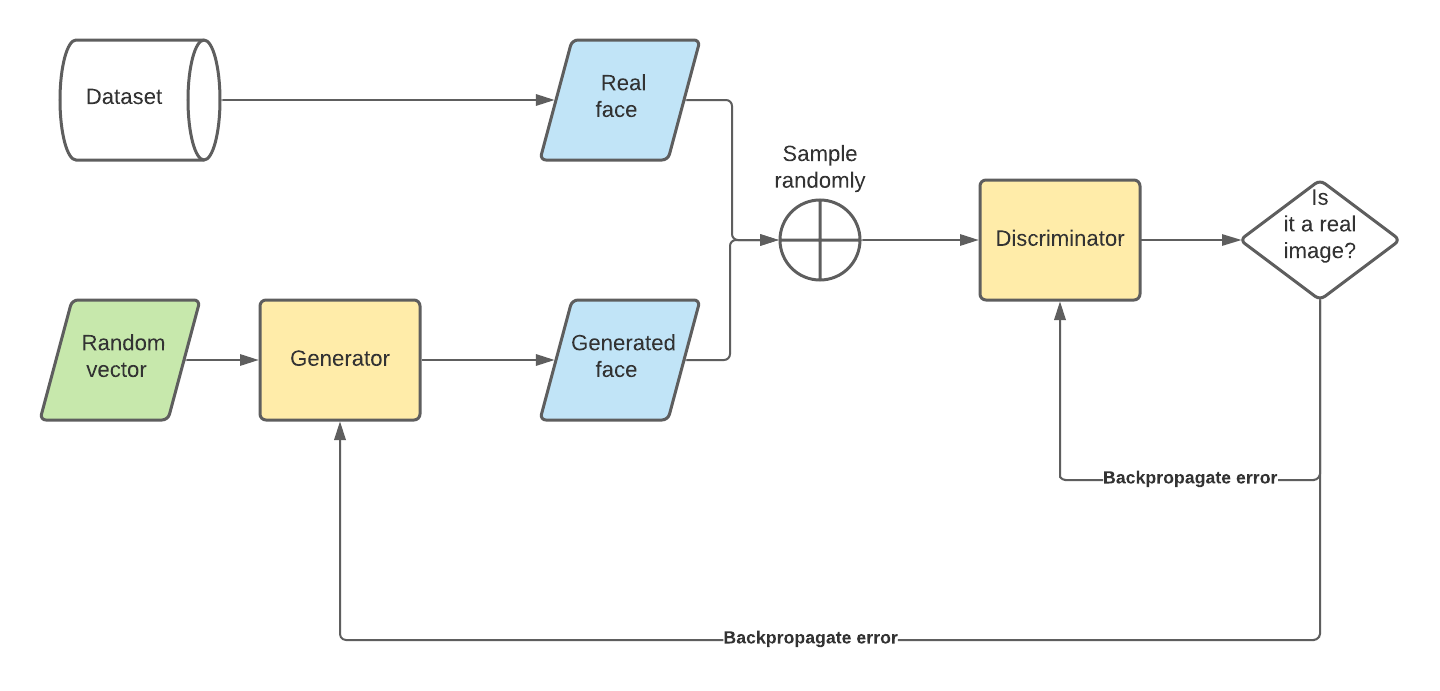



Progressive Growing GAN is an extension to the GAN training process that allows for the stable training of generator models that can output large high-quality images.

It involves starting with a very small image and incrementally adding blocks of layers that increase the output size of the generator model and the input size of the discriminator model until the desired image size is achieved. This approach has proven effective at generating high-quality synthetic faces that are startlingly realistic.

A solution to the problem of training stable GAN models for larger images is to progressively increase the number of layers during the training process.

This approach is called Progressive Growing GAN, Progressive GAN, or PGGAN for short.

Progressive Growing GAN involves using a generator and discriminator model with the same general structure and starting with very small images, such as 4×4 pixels.

During training, new blocks of convolutional layers are systematically added to both the generator model and the discriminator models.

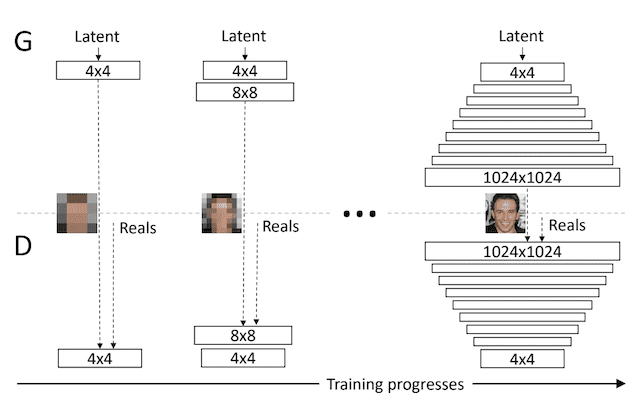

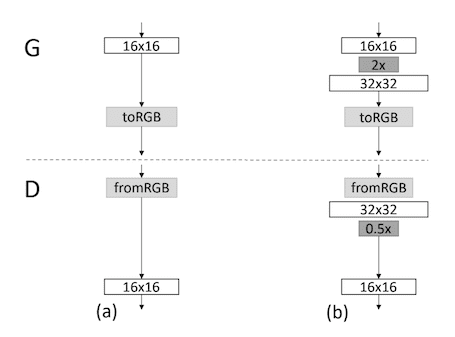

The main issue with this technic is that it create artifacts such as the following:
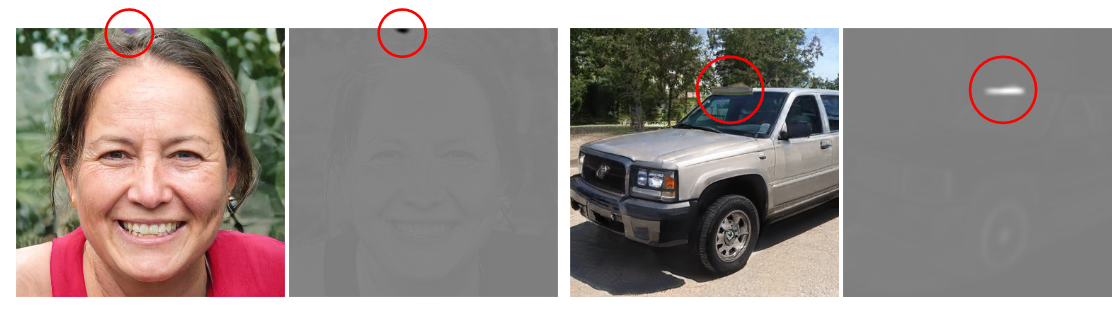

So they used the same type of architecture as MSG-GAN:

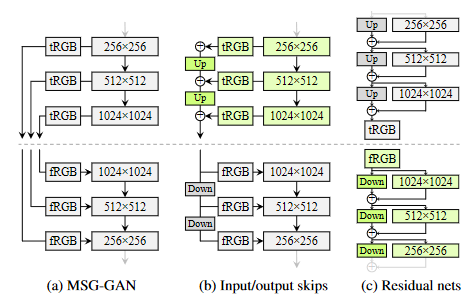

## **StyleGAN2 ADA**


Training generative adversarial networks (GAN) using too little data typically leadsto discriminator overfitting, causing training to diverge. THis is why theyr proposed an adaptive discriminator augmentation mechanism that significantly stabilizes training inlimited data regimes.  

The approach does not require changes to loss functionsor network architectures, and is applicable both when training from scratch and when fine-tuning an existing GAN on another dataset. 

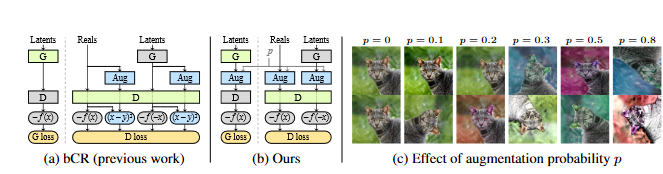

## **Code workflow**

## **Code**

## Setup

In [ ]:
# Mount G-Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
!pip install -U kora

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (55/55), done.
     |████████████████████████████████| 112kB 8.7MB/s 


## Libraries

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy
import random

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure

from tqdm.notebook import tqdm

## Functions

In [ ]:
def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)
  

In [ ]:
def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    
    return images[0]


In [ ]:
def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
          
  return label


In [ ]:
def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')


In [ ]:
def expand_seed(seeds, vector_size):
  result = []
  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 

  return result


## Generate Faces


In [ ]:
URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...


Create frame-678.png


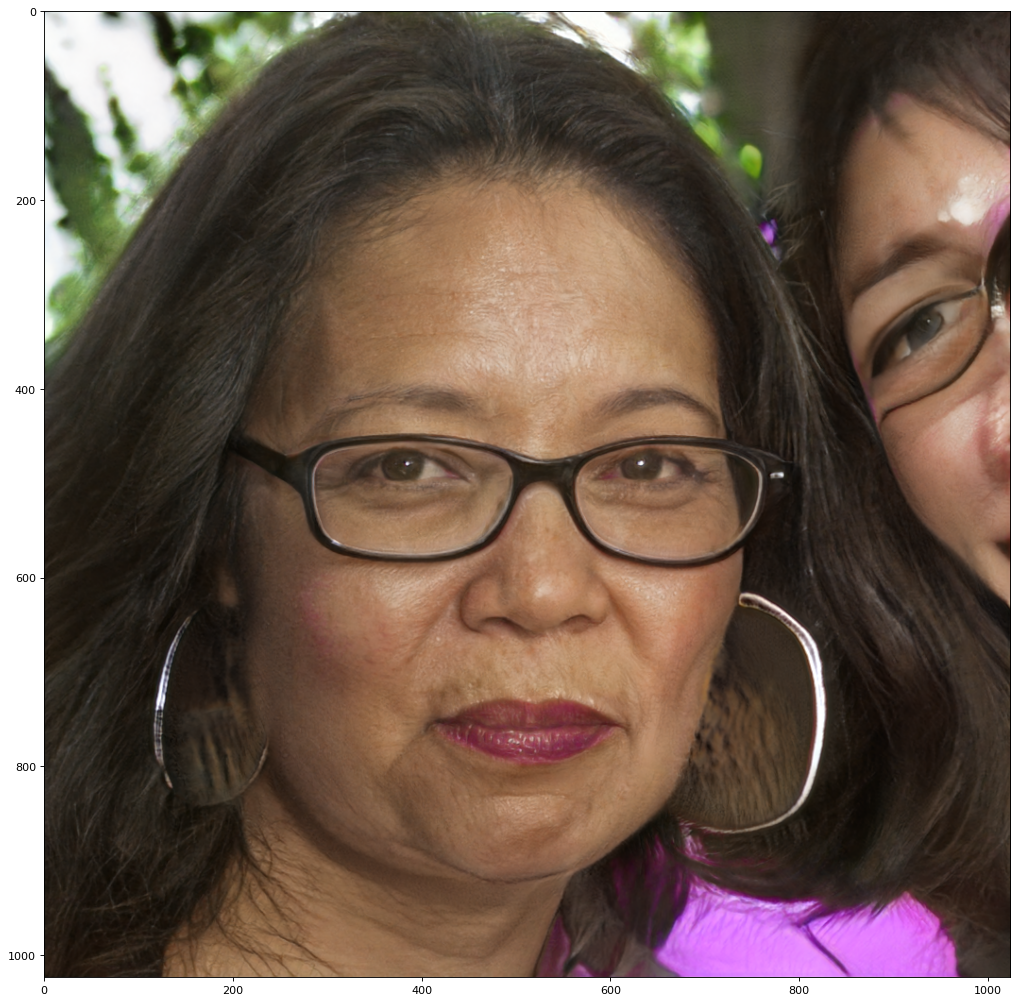

In [ ]:
SEED = random.randint(1,5000)
v = seed2vec(G, SEED)
img = generate_image(device, G, v)
img.save(f'/content/drive/My Drive/stylegan2/frame-{SEED}.png')
print(f'Create frame-{SEED}.png')

%matplotlib inline
testim = mpimg.imread(f'/content/drive/My Drive/stylegan2/frame-{SEED}.png')
figure(figsize=(16, 16), dpi=80)
imshow(testim)

In [ ]:
# Choose your seeds to morph through and the number of steps to take to get to each.

SEEDS = [1003,1052,1070,1003]
STEPS = 100

# Remove any prior results
!rm /content/results/* 

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y '/content/drive/My Drive/stylegan2_movie/movie.mp4'


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [ ]:
files.download('/content/drive/My Drive/stylegan2_movie/movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>